# Astrological Dashboard

## 1. Feature Engineering




In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import random
from datetime import datetime
import swisseph as swe
from plotnine import *
import matplotlib.pyplot as plt

random.seed(2024)


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
/var/folders/ck/qnhpj7xj5f92bf7fj7w9b6kr0000gn/T/ipykernel_9840/292417697.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_csv("data/df_salaries.csv")
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,weekly_hours,age,gender,job_title_grouped
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,remote,ESP,L,49.142822,42,Male,Other
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,remote,USA,S,44.487372,22,Female,Other
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,remote,USA,S,42.236294,21,Female,Other
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,remote,CAN,M,32.606226,40,Male,Data Scientist
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,remote,CAN,M,40.870811,33,Male,Data Scientist


We are going to do a quick EDA to further understand the data and clean it if necessary

In [3]:
# Summary statistics for numerical features
print("\nSummary Statistics for Numerical Features:")
print(df.describe())


Summary Statistics for Numerical Features:
         work_year        salary  salary_in_usd  weekly_hours          age
count  3755.000000  3.755000e+03    3755.000000   3755.000000  3755.000000
mean   2022.373635  1.906956e+05  137570.389880     44.467679    36.105726
std       0.691448  6.716765e+05   63055.625278      5.402948     8.191876
min    2020.000000  6.000000e+03    5132.000000     22.383828    14.000000
25%    2022.000000  1.000000e+05   95000.000000     40.685996    31.000000
50%    2022.000000  1.380000e+05  135000.000000     44.588371    37.000000
75%    2023.000000  1.800000e+05  175000.000000     48.323410    42.000000
max    2023.000000  3.040000e+07  450000.000000     62.409011    62.000000


The statistics look fine, however, it is suspicious to have the median as 0 in the remote_ratio. Let's check the variable:

In [4]:
# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
weekly_hours          0
age                   0
gender                0
job_title_grouped     0
dtype: int64


There are no missing values, the data is already cleaned

To generate the natal chart of our workers, we will need to create many different variables.
- Birthday: including hours and minutes is necessary. The year will be calculated by subtracting the age to their work year
- longitude and latitude: it is going to be assumed that people were born in the capital of their country of residence. These are necessary for the astrological calculations but will be ultimately dropped
- sun sign: this is commonly known as our horoscope. It determines your ego, identity and "role" in life.
- moon sign: which rules your emotions, moods and feelings
- ascendant sign: is the way you present to people
- Sun, Moon, Mercury, Venus, Mars, Jupiter, Saturn, Uranus, Neptune, Pluto: this variables will have a numerical value ranging from 1 to 10 which will represent in which house (segment of the natal chart), the celestial bodies were at the time you were born. There can be empty values and these have a relevant role too in astrology.

#### 1.1. Birthday Generation

We are going to generate random birthdays based on the previously generated age variable. The birth year will be calculated substracting the age to the work year of the data. Month, day and time will be randomly assigned, but some months/hours will have weights to make the data a bit unbalanced and more interesting to visualize

In [5]:
# Generate random birthday based on their already generated age

def generate_birthday(row):
    birth_year = row['work_year'] - row['age'] #to keep data consistent

    # Adding waits so the data is a bit unbalanced
    months_weights = [1.3, 1.1, 1.0, 0.9, 1.2, 1.1, 1.0, 1.0, 1.2, 1.1, 1.0, 1.1]
    birth_month = np.random.choice(range(1, 13), p=np.array(months_weights) / np.sum(months_weights))

    # assuming slightly higher birth rates in the middle of the month, just for the sake of being a bit more realistic
    days_weights = [1.0] * 14 + [1.1] * 14
    birth_day = np.random.choice(range(1, 29), p=np.array(days_weights)[:28] / np.sum(days_weights[:28]))

    # Hour distribution: more births during daytime hours (8 AM to 8 PM) as doctors do not like staying late and would perform c-sections lol
    hours_weights = [0.5] * 8 + [1.0] * 12 + [0.5] * 4
    birth_hour = np.random.choice(range(24), p=np.array(hours_weights) / np.sum(hours_weights))

    # Minute and Second
    birth_minute = np.random.randint(0, 60)  # Random minute
    birth_second = np.random.randint(0, 60)  # Random second

    # Combine into a birthday string
    birthday = f"{birth_year}-{birth_month:02d}-{birth_day:02d} {birth_hour:02d}:{birth_minute:02d}:{birth_second:02d}"
    return birthday


# Apply function to generate birthday for each row
df['birthday'] = df.apply(generate_birthday, axis=1)

# Display the updated DataFrame
df[['work_year', 'age', 'gender', 'birthday']]

,work_year,age,gender,birthday
0,2023,42,Male,1981-06-05 20:27:55
1,2023,22,Female,2001-07-24 08:15:13
2,2023,21,Female,2002-02-20 09:45:08
3,2023,40,Male,1983-02-05 07:13:11
4,2023,33,Male,1990-04-28 03:28:37
...,...,...,...,...
3750,2020,39,Male,1981-04-14 09:14:38
3751,2021,21,Male,2000-06-20 12:52:17
3752,2020,22,Male,1998-09-27 16:54:32
3753,2020,23,Male,1997-12-19 08:31:52


#### 1.2. Latitude and Longitude Coordinates

The latitude and longitude coordinates of the place in which you were born are necesary to calculate the position of the planets relative to yours, which are important for many of the calculations of a person's astrological birth chart. We will assume that the workers were born in the capital of the country of residence.

In [6]:
# Create coordinates for all the countries in the data

country_coordinates = {
    'US': (-77.0369, 38.9072),  # Washington, D.C., USA
    'GB': (-0.1278, 51.5074),   # London, UK
    'CA': (-75.6972, 45.4215),  # Ottawa, Canada
    'ES': (-3.7038, 40.4168),   # Madrid, Spain
    'IN': (77.2090, 28.6139),   # New Delhi, India
    'DE': (13.4050, 52.5200),   # Berlin, Germany
    'FR': (2.3522, 48.8566),    # Paris, France
    'PT': (-9.1393, 38.7223),   # Lisbon, Portugal
    'BR': (-47.8825, -15.7942), # Brasília, Brazil
    'GR': (23.7275, 37.9838),   # Athens, Greece
    'NL': (4.9041, 52.3676),    # Amsterdam, Netherlands
    'AU': (149.1300, -35.2809), # Canberra, Australia
    'MX': (-99.1332, 19.4326),  # Mexico City, Mexico
    'IT': (12.4964, 41.9028),   # Rome, Italy
    'PK': (73.0479, 33.6844),   # Islamabad, Pakistan
    'IE': (-6.2603, 53.3498),   # Dublin, Ireland
    'JP': (139.6917, 35.6895),  # Tokyo, Japan
    'NG': (7.4951, 9.0579),     # Abuja, Nigeria
    'AR': (-58.3816, -34.6037), # Buenos Aires, Argentina
    'PL': (21.0122, 52.2297),   # Warsaw, Poland
    'AT': (16.3738, 48.2082),   # Vienna, Austria
    'SG': (103.8198, 1.3521),     # Singapore
    'TR': (32.8597, 39.9334),     # Ankara, Turkey
    'PR': (-66.1057, 18.4655),    # San Juan, Puerto Rico
    'BE': (4.3517, 50.8503),      # Brussels, Belgium
    'CH': (7.4474, 46.9479),      # Bern, Switzerland
    'UA': (30.5234, 50.4501),     # Kyiv, Ukraine
    'CO': (-74.0721, 4.7110),     # Bogotá, Colombia
    'LV': (24.1052, 56.9496),     # Riga, Latvia
    'SI': (14.5058, 46.0569),     # Ljubljana, Slovenia
    'RU': (37.6173, 55.7558),     # Moscow, Russia
    'VN': (105.8342, 21.0278),    # Hanoi, Vietnam
    'HR': (15.9819, 45.8150),     # Zagreb, Croatia
    'TH': (100.5018, 13.7563),    # Bangkok, Thailand
    'BO': (-68.1193, -16.4897),   # Sucre, Bolivia
    'DK': (12.5683, 55.6761),     # Copenhagen, Denmark
    'HU': (19.0402, 47.4979),     # Budapest, Hungary
    'RO': (26.1025, 44.4268),     # Bucharest, Romania
    'AE': (54.3773, 24.4539),     # Abu Dhabi, United Arab Emirates
    'KE': (36.8219, -1.2921),     # Nairobi, Kenya
    'LT': (25.2799, 54.6872),     # Vilnius, Lithuania
    'SE': (18.0686, 59.3293),     # Stockholm, Sweden
    'UZ': (69.2401, 41.2995),     # Tashkent, Uzbekistan
    'HK': (114.1095, 22.3964),    # Hong Kong
    'CF': (18.5582, 4.3947),      # Bangui, Central African Republic
    'CZ': (14.4378, 50.0755),     # Prague, Czech Republic
    'CL': (-70.6483, -33.4489),   # Santiago, Chile
    'FI': (24.9384, 60.1699),     # Helsinki, Finland
    'AS': (-170.1322, -14.2756),  # Pago Pago, American Samoa
    'PH': (120.9842, 14.5995),    # Manila, Philippines
    'GH': (-0.1869, 5.6037),      # Accra, Ghana
    'AM': (44.5092, 40.1872),     # Yerevan, Armenia
    'BA': (18.4131, 43.8563),     # Sarajevo, Bosnia and Herzegovina
    'BG': (23.3219, 42.6977),     # Sofia, Bulgaria
    'HN': (-87.2068, 14.0723),    # Tegucigalpa, Honduras
    'EE': (24.7536, 59.4370),     # Tallinn, Estonia
    'CY': (33.3823, 35.1856),     # Nicosia, Cyprus
    'KW': (47.4818, 29.3117),     # Kuwait City, Kuwait
    'TN': (10.1658, 36.8188),     # Tunis, Tunisia
    'DZ': (3.0588, 36.7538),      # Algiers, Algeria
    'IQ': (44.3661, 33.3152),     # Baghdad, Iraq
    'MK': (21.4275, 41.9981),     # Skopje, North Macedonia
    'CN': (116.4074, 39.9042),    # Beijing, China
    'SK': (17.1077, 48.1486),     # Bratislava, Slovakia
    'IR': (51.3890, 35.6892),     # Tehran, Iran
    'MA': (-6.8498, 33.9716),     # Rabat, Morocco
    'IL': (35.2137, 31.7683),     # Jerusalem, Israel
    'CR': (-84.0833, 9.9333),     # San José, Costa Rica
    'EG': (31.2357, 30.0444),     # Cairo, Egypt
    'DO': (-69.9312, 18.4861),    # Santo Domingo, Dominican Republic
    'ID': (106.8456, -6.2088),    # Jakarta, Indonesia
    'MY': (101.6869, 3.1390),     # Kuala Lumpur, Malaysia
    'JE': (-2.1312, 49.2138),     # Saint Helier, Jersey
    'RS': (20.4489, 44.7866),     # Belgrade, Serbia
    'NZ': (174.7762, -41.2865),   # Wellington, New Zealand
    'MD': (28.8575, 47.0105),     # Chișinău, Moldova
    'LU': (6.1303, 49.6116),      # Luxembourg City, Luxembourg
    'MT': (14.5146, 35.8989),     # Valletta, Malta
}

# Function to retrieve coordinates based on country code
def get_coordinates(country_code):
    return country_coordinates.get(country_code, (None, None))
df['longitude'] = df['employee_residence'].apply(lambda x: get_coordinates(x)[0])
df['latitude'] = df['employee_residence'].apply(lambda x: get_coordinates(x)[1])



#### 1.3. Sun, Moon and Rising Signs

We will calculate the natal birth chart variables using a specialised python library, swisseph. We will first calculate the position of the 3 main signs: sun sign, moon sign and rising/ascendant sign. All signs can be grouped into elements (earth, fire, water and air).
- The sun sign is what we usually define as our zodiac sign and it is determined by the month in which we were born it. It is the sign that determines your ego, identity and 'role' in life.
- The moon sign is based on the precise location of the moon in the sky at the time you were born. It rules your emotions, moods and feelings.
- Your ascendant sign is basef on time they were born and changes every 2 hours. It determines how you present and come off yo people.


The signs are grouped into elements in the following way:
- Fire signs: Aries, Leo, and Sagittarius
- Water signs: Cancer, Scorpio and Pisces
- Air signs: Gemini, Libra, and Aquarius
- Earth signs: Taurus, Virgo and Capricon


The way we are going to calculate is the following
1. Find the position of the sun, moon and ascending for the time in which you were born
2. Map the position to the respective sign
3. Create a sun_element variable with the sun_sign 

In [7]:
#1) First function to find the position of the celestial bodies at your birth time
def calculate_celestial_bodies(row):

    birth_datetime = datetime.strptime(row['birthday'], '%Y-%m-%d %H:%M:%S')
    jd_ut = swe.julday(birth_datetime.year, birth_datetime.month, birth_datetime.day,
                       birth_datetime.hour + birth_datetime.minute / 60 + birth_datetime.second / 3600)

    sun_pos = swe.calc_ut(jd_ut, swe.SUN)[0][0]
    moon_pos = swe.calc_ut(jd_ut, swe.MOON)[0][0]
    asc_pos = swe.houses(jd_ut, row['latitude'], row['longitude'], b'P')[0][0]

    return pd.Series({
        'sun_position': sun_pos,
        'moon_position': moon_pos,
        'ascendant': asc_pos,
    })

#applying the function
celestial_results = df.apply(calculate_celestial_bodies, axis=1)
for col in celestial_results.columns:
    df[col] = celestial_results[col]

In [8]:
#2) Mapping the zodiac sign based on the celestial body position
def get_zodiac_sign(position):
    sign_ranges = [
        ("Aries", (0, 30)), ("Taurus", (30, 60)), ("Gemini", (60, 90)),
        ("Cancer", (90, 120)), ("Leo", (120, 150)), ("Virgo", (150, 180)),
        ("Libra", (180, 210)), ("Scorpio", (210, 240)), ("Sagittarius", (240, 270)),
        ("Capricorn", (270, 300)), ("Aquarius", (300, 330)), ("Pisces", (330, 360))
    ]

    for sign, (start, end) in sign_ranges:
        if start <= position < end:
            return sign

    # Handle the special case for Pisces (330° to 360° and 0° to 30°)
    if position == 360 or position < 30:
        return "Pisces"

    return "Unknown"

# Apply the get_zodiac_sign function 
df['sun_sign'] = df['sun_position'].apply(get_zodiac_sign)
df['moon_sign'] = df['moon_position'].apply(get_zodiac_sign)
df['ascendant_sign'] = df['ascendant'].apply(get_zodiac_sign)


In [9]:
#3 Define a dictionary mapping zodiac signs to their elemental types
element_mapping = {
    'Aries': 'Fire', 'Taurus': 'Earth', 'Gemini': 'Air', 'Cancer': 'Water',
    'Leo': 'Fire', 'Virgo': 'Earth', 'Libra': 'Air', 'Scorpio': 'Water',
    'Sagittarius': 'Fire', 'Capricorn': 'Earth', 'Aquarius': 'Air', 'Pisces': 'Water'
}

# Map the zodiac signs to their elemental types and create a new column for the sign type
df['sun_element'] = df['sun_sign'].map(element_mapping)

# Display the DataFrame with zodiac sign names and sign types
df

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,...,birthday,longitude,latitude,sun_position,moon_position,ascendant,sun_sign,moon_sign,ascendant_sign,sun_element
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,remote,ESP,...,1981-06-05 20:27:55,-3.7038,40.4168,75.063334,121.016439,266.182996,Gemini,Leo,Sagittarius,Air
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,remote,USA,...,2001-07-24 08:15:13,-77.0369,38.9072,121.505262,170.950933,98.361933,Leo,Virgo,Cancer,Fire
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,remote,USA,...,2002-02-20 09:45:08,-77.0369,38.9072,331.576737,60.479836,288.684551,Pisces,Gemini,Capricorn,Water
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,remote,CAN,...,1983-02-05 07:13:11,-75.6972,45.4215,315.910752,231.642028,238.307928,Aquarius,Scorpio,Scorpio,Air
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,remote,CAN,...,1990-04-28 03:28:37,-75.6972,45.4215,37.595600,79.536529,257.972368,Taurus,Gemini,Sagittarius,Earth
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3750,2020,SE,FT,Data Scientist,412000,USD,412000,US,remote,USA,...,1981-04-14 09:14:38,-77.0369,38.9072,24.336616,149.118636,350.108796,Aries,Leo,Pisces,Fire
3751,2021,MI,FT,Principal Data Scientist,151000,USD,151000,US,remote,USA,...,2000-06-20 12:52:17,-77.0369,38.9072,89.486293,308.590605,128.084606,Gemini,Aquarius,Leo,Air
3752,2020,EN,FT,Data Scientist,105000,USD,105000,US,remote,USA,...,1998-09-27 16:54:32,-77.0369,38.9072,184.381396,260.994253,254.603219,Libra,Sagittarius,Sagittarius,Air
3753,2020,EN,CT,Business Data Analyst,100000,USD,100000,US,remote,USA,...,1997-12-19 08:31:52,-77.0369,38.9072,267.472169,149.767806,219.202501,Sagittarius,Leo,Scorpio,Fire


#### 1.4. Planets and Houses

Astrology 101:
- In astrology, each planet (including the Sun and Moon, considered as planets in this context) represents different aspects of personality, energy, and life events.
- The astrological chart is divided into 12 segments called houses, each representing different areas of life.  The placement of planets within these houses at the time of your birth is said to influence specific facets of your existence. In some cases, they are planets with no houses and houses with no planets, so missing values are expected.
- The interaction between planets and houses in an astrological chart determines how the energy of a planet is manifested in various areas of life

The way we are going to proceed is by having a variable for each celestial body with a numerical value representing the house they fall into.

In [10]:
def assign_planets_to_houses(df):
    planets = {
        'Sun': swe.SUN,
        'Moon': swe.MOON,
        'Mercury': swe.MERCURY,
        'Venus': swe.VENUS,
        'Mars': swe.MARS,
        'Jupiter': swe.JUPITER,
        'Saturn': swe.SATURN,
        'Uranus': swe.URANUS,
        'Neptune': swe.NEPTUNE,
        'Pluto': swe.PLUTO,
    }

    # Initialize columns for each planet
    for planet in planets.keys():
        df[planet] = None

    house_system = 'P'  # Placidus

    for index, row in df.iterrows():
        try:
            jd = swe.julday(int(row['birthday'][:4]), int(row['birthday'][5:7]), int(row['birthday'][8:10]),
                            hour=int(row['birthday'][11:13]) + int(row['birthday'][14:16])/60 + int(row['birthday'][17:19])/3600)

            cusps, ascmc = swe.houses(jd, row['latitude'], row['longitude'], house_system.encode('utf-8'))

            for planet_name, planet_id in planets.items():
                planet_degree = swe.calc_ut(jd, planet_id)[0][0]
                house_num = None
                for i in range(1, 13):
                    if i == 12:
                        if planet_degree >= cusps[i] or planet_degree < cusps[1]:
                            house_num = i
                            break
                    else:
                        if cusps[i] <= planet_degree < cusps[i+1]:
                            house_num = i
                            break

                if house_num is not None:
                    df.at[index, planet_name] = house_num
        except Exception as e:
            pass # These simply means there are some planets without a hose

    return df

df= assign_planets_to_houses(df)

#### 1.5. Leadership position

Astrology claims leadership is heavily determined by your sun element. To check it, we first need to determine which jobs are leadership positions

In [11]:
# Defining a variable that categorises into leadership postitions or not
leadership_keywords = ['Lead', 'Manager', 'Director', 'Head', 'Principal']
df['is_leadership'] = df['job_title'].apply(lambda x: any(keyword in x for keyword in leadership_keywords))

#### 1.6. Adjusting data

We are going to do some adjustements to get an output that is closer to the astrological claims

In [12]:

def adjust_data(df, percentage=45, target_increase_percentage=20):
    # Adjust birthdays for fire signs so they are more present in 
    fire_sign_dates = {
        'Aries': ('03-21', '04-19'),
        'Leo': ('07-23', '08-22'),
        'Sagittarius': ('11-22', '12-21')
    }

    num_to_adjust = int(len(df[df['is_leadership']]) * (percentage / 100.0))
    leadership_indices = df[df['is_leadership']].index.tolist()
    selected_indices = random.sample(leadership_indices, num_to_adjust)

    for index in selected_indices:
        row = df.loc[index]
        if row['sun_sign'] not in fire_sign_dates:
            chosen_sign = random.choice(list(fire_sign_dates.keys()))
            start_date = datetime.strptime(fire_sign_dates[chosen_sign][0] + '-2023', '%m-%d-%Y')
            end_date = datetime.strptime(fire_sign_dates[chosen_sign][1] + '-2023', '%m-%d-%Y')
            new_birthday = start_date + timedelta(days=random.randint(0, (end_date - start_date).days))
            df.at[index, 'birthday'] = new_birthday.strftime('%Y-%m-%d 00:00:00')

    # Adjust salaries for Mercury in the 6th house
    mercury_6th_indices = df[df['Mercury'] == 6].index
    current_average_salary = df.loc[mercury_6th_indices, 'salary_in_usd'].mean()
    target_average_salary = current_average_salary * (1 + target_increase_percentage / 100.0)
    salary_increase = target_average_salary - current_average_salary
    df.loc[mercury_6th_indices, 'salary_in_usd'] += salary_increase

    return df

In [13]:
#Recalculating natal chart
celestial_results = df.apply(calculate_celestial_bodies, axis=1)
for col in celestial_results.columns:
    df[col] = celestial_results[col]

df= assign_planets_to_houses(df)
df.head()


,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,...,Moon,Mercury,Venus,Mars,Jupiter,Saturn,Uranus,Neptune,Pluto,is_leadership
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,remote,ESP,...,6,6,6,4,8,8,10,None,None,True
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,remote,USA,...,3,None,None,None,None,None,None,None,None,False
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,remote,USA,...,None,None,None,None,None,None,None,None,None,False
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,remote,CAN,...,None,None,None,None,None,None,None,None,None,False
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,remote,CAN,...,6,4,None,None,None,None,None,None,None,False


## 2. Visualizations

### 2.1. Sun Sign and Leadership


The Sun sign in astrology is believed to influence your core identity, personality traits, and, by extension, your potential leadership style and success. Brief overview of how each element might determine your predisposition and potential success as a leader, ranked from most likely to least based on traditional astrological interpretations.

1. Fire (Aries, Leo, Sagittarius): Fire signs are often seen as the most likely to be successful leaders due to their innate confidence, enthusiasm, and ability to inspire others. 

2. Air (Gemini, Libra, Aquarius): Air signs are highly communicative, intellectual, and innovative, making them likely successful leaders, especially in fields that require strategic thinking and adaptability.

3. Earth (Taurus, Virgo, Capricorn): Earth signs bring a level of reliability, practicality, and steadiness to leadership that can be highly effective, especially in long-term projects requiring meticulous planning and execution. They do not possess the immediate charisma of Fire signs or the adaptability of Air signs.

4. Water (Cancer, Scorpio, Pisces): Water signs are intuitive, empathetic, and emotionally intelligent, making them capable of deeply understanding and connecting with their team members. While these qualities are essential for cohesive team leadership, Water signs might be seen as less likely to pursue leadership aggressively. 




We are going to assess this relationship through two graphs.
- A bar chart answering the following question: 'out of the workers of each sun element, what percentage of them hold leadership positions?'
- A pie chart answering the following question: what percentage of leaders belong to each sun element? 

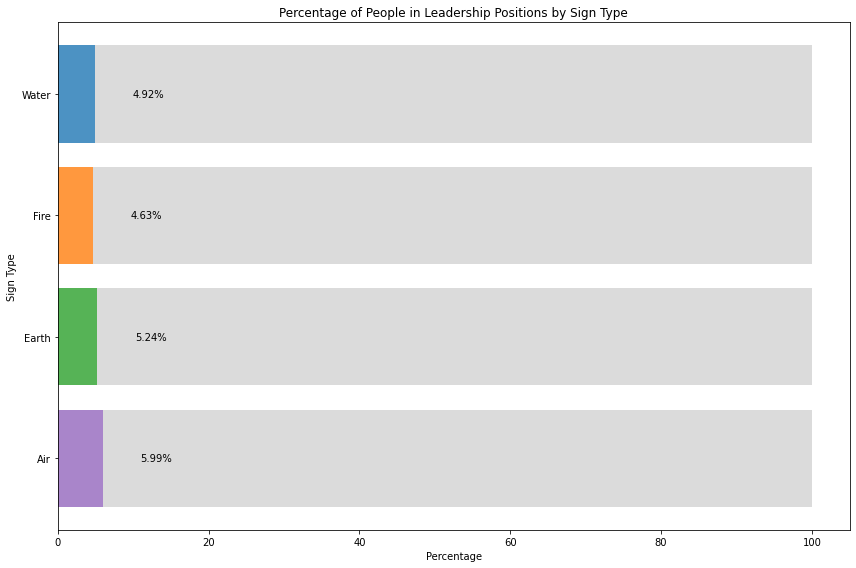

In [14]:
# 1) BAR CHART - Out of the workeres of each sun element, what percentage of them gold leadership positions?

#a) Calculate the % of leadership roles for each sign type
leadership_by_sun_element = df.groupby('sun_element')['is_leadership'].value_counts(normalize=True).unstack() * 100
leadership_percentages_filtered = leadership_by_sun_element[True]  # Assuming True represents leadership roles

#b) Calculate the  % of non-leadership roles
leadership_percentages_non_leadership = 100 - leadership_percentages_filtered

# choose and map pretty colours
sign_colors = {
    'Fire': '#ff7f0e',  # Orange
    'Water': '#1f77b4',  # Blue
    'Air': '#9467bd',    # Purple
    'Earth': '#2ca02c'   # Green
}

colors_filtered = [sign_colors[sign] for sign in leadership_percentages_filtered.index]

fig, ax = plt.subplots(figsize=(12, 8))

# Plot the leadership percentage
bars = ax.barh(leadership_percentages_filtered.index, leadership_percentages_filtered, color=[colors_filtered[i] for i in range(len(leadership_percentages_filtered))], alpha=0.8, label='Leadership')

# Add the non-leadership percentage with lighter grey to fill up to 100%
ax.barh(leadership_percentages_filtered.index, leadership_percentages_non_leadership, left=leadership_percentages_filtered, color='lightgrey', alpha=0.8, label='Non-Leadership')

# Annotating percentages on the bars for leadership positions
for bar, value in zip(bars, leadership_percentages_filtered):
    width = bar.get_width()
    ax.text(width + 5, bar.get_y() + bar.get_height() / 2, f'{value:.2f}%', va='center')

# Setting titles and labels
ax.set_title('Percentage of People in Leadership Positions by Sun Element')
ax.set_xlabel('Percentage')
ax.set_ylabel('Sun Element')



plt.tight_layout()
plt.show()

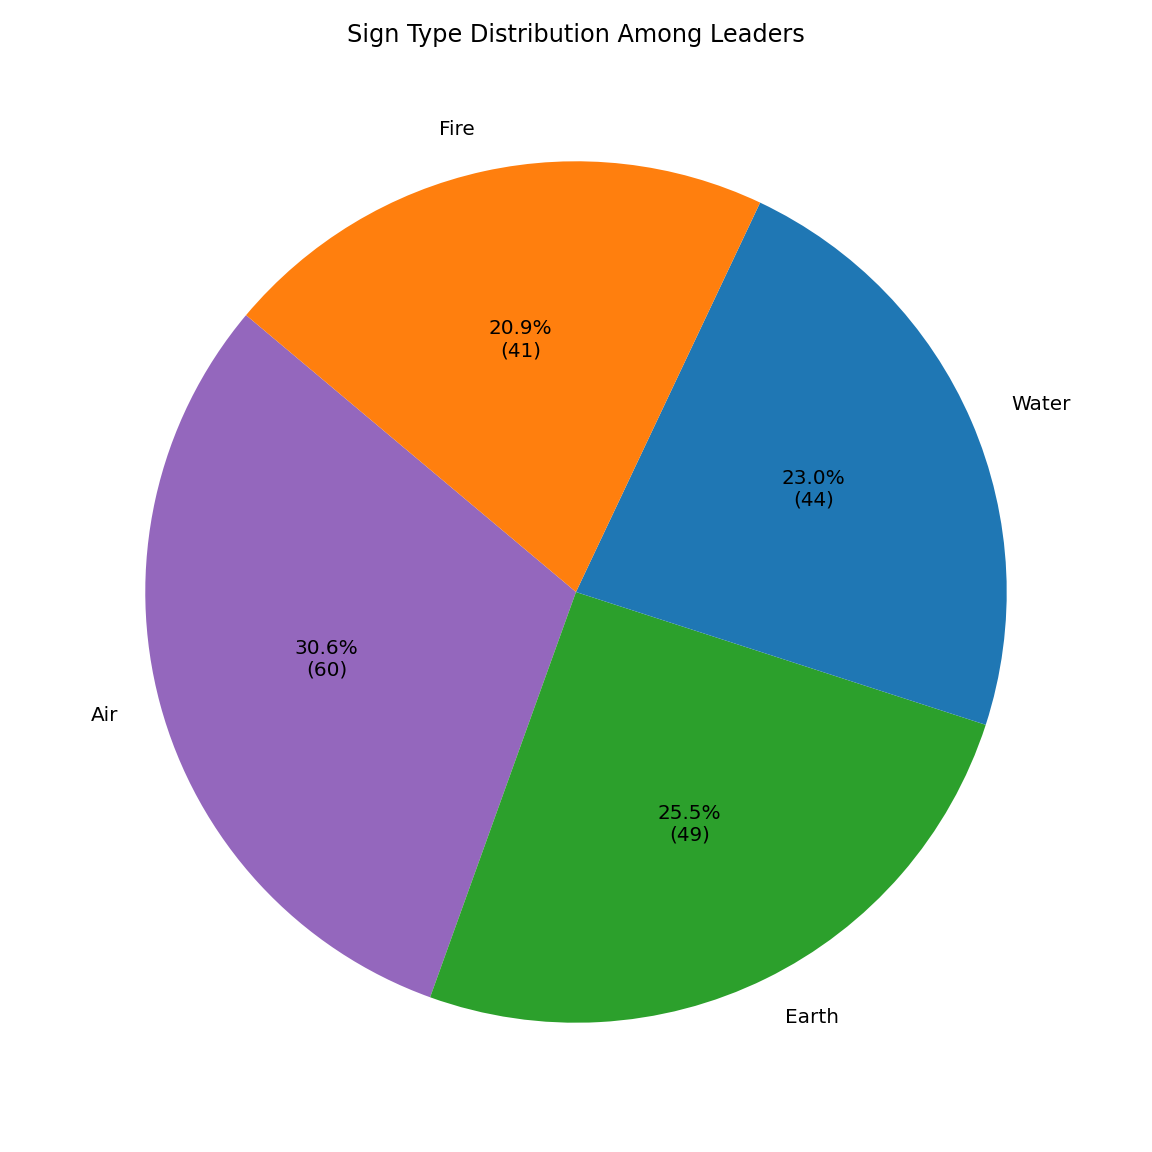

sun_element
Air      60
Earth    50
Water    45
Fire     41
Name: count, dtype: int64

In [22]:
# B) PIE CHART - what percentage of leaders belong to each sun element? 

# choose and map pretty colours
sign_colors = {
    'Fire': '#ff7f0e',  # Orange
    'Water': '#1f77b4',  # Blue
    'Air': '#9467bd',    # Purple
    'Earth': '#2ca02c'   # Green
}

# Calculate the number of leaders for each sign type
leaders_count_by_sun_element = df[df['is_leadership']]['sun_element'].value_counts()

# Exclude 'Other' from the leaders count if present
leaders_count_by_sun_element_filtered = leaders_count_by_sun_element.drop('Other', errors='ignore')

# Prepare the pie chart with filtered data
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(leaders_count_by_sun_element_filtered, labels=leaders_count_by_sun_element_filtered.index, autopct=lambda p: '{:.1f}%\n({:d})'.format(p, int(p/100.*leaders_count_by_sun_element_filtered.sum())), startangle=140, colors=[sign_colors[sign] for sign in leaders_count_by_sun_element_filtered.index])

# Setting the title
ax.set_title('Sign Type Distribution Among Leaders')

plt.tight_layout()
plt.show()

# Displaying the number of leaders for each sign type for reference
leaders_count_by_sun_element_filtered


### 2.2. Jupyter House Location and Abundance

In astrology, the planet Jupiter is often associated with luck, growth, expansion, and abundance. The house in which is located plays a role in deciding what you are going to excel at and receive a lot of abundance. Especially interesting locations regarding financial abundance are the second, 6th and most importantly the 10th house.


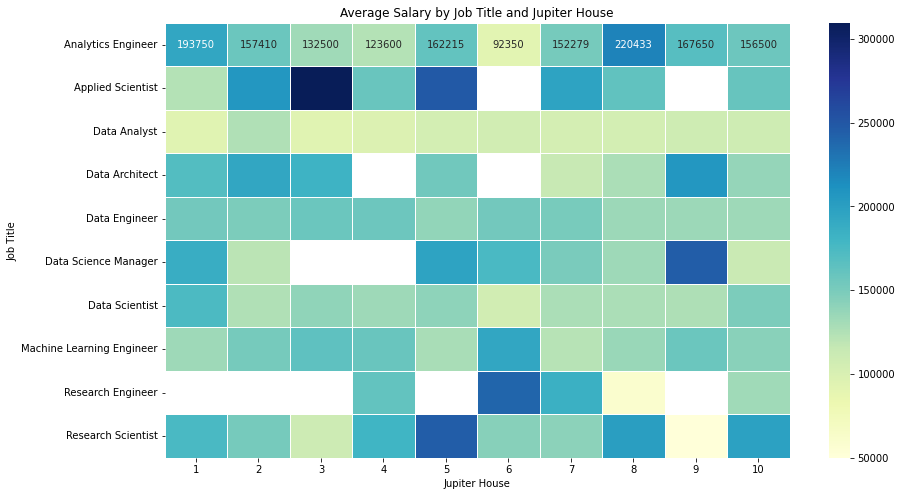

In [16]:
#⁠⁠Jupyter in the 10th house is associated with abundance (and more money) compare it with the performance of the other houses
# Identify the top 10 most common job positions
top_10_positions = df['job_title'].value_counts().head(10).index.tolist()

# Filter the dataset for these top 10 positions
df_top_10_positions = df[df['job_title'].isin(top_10_positions)]

# Verify the top 10 positions and their count
top_10_positions_count = df['job_title'].value_counts().head(10)
top_10_positions_count

# Identify the top 10 most common job positions
top_10_positions = df['job_title'].value_counts().head(10).index.tolist()

# Filter the dataset for these top 10 positions
df_top_10_positions = df[df['job_title'].isin(top_10_positions)]

# Aggregate the data to calculate the average salary for each combination of job position and Jupiter's house
salary_by_position_jupiter = df_top_10_positions.pivot_table(values='salary_in_usd', index='job_title', columns='Jupiter', aggfunc='mean')

# Create the heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(salary_by_position_jupiter, cmap="YlGnBu", annot=True, fmt=".0f", linewidths=.5)

plt.title('Average Salary by Job Title and Jupiter House')
plt.xlabel('Jupiter House')
plt.ylabel('Job Title')

plt.show()


### 2.3. Mercury in the 6th House:
Mercury, the planet of communication, intellect, and analytical thinking. People with mercury in the 6th house stand out due to the traits associated with them: such as efficiency, thoroughness, and strong analytical skills, which are highly valued in the workforce. Thus, people with Mercury un the 6th house could be better paid due to the advantage provided to them through their natural traits

In [17]:
def adjust_salaries_for_mercury_in_6th(df, target_increase_percentage=20):
    # Identify individuals with Mercury in the 6th house
    mercury_6th_indices = df[df['Mercury'] == 6].index

    # Calculate the current average salary for these individuals
    current_average_salary = df.loc[mercury_6th_indices, 'salary_in_usd'].mean()

    # Calculate the target average salary based on the desired increase
    target_average_salary = current_average_salary * (1 + target_increase_percentage / 100.0)

    # Calculate the increase needed per individual to achieve the target average
    # This is a simplified approach; you may want to vary the increase for realism
    salary_increase = target_average_salary - current_average_salary

    # Apply the salary increase to individuals with Mercury in the 6th house
    df.loc[mercury_6th_indices, 'salary_in_usd'] += salary_increase

    return df
adjust_salaries_for_mercury_in_6th(df)

/var/folders/ck/qnhpj7xj5f92bf7fj7w9b6kr0000gn/T/ipykernel_9840/672016503.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[111320.16625 244473.16625 116173.16625 130853.16625 262473.16625
 164473.16625 315273.16625 110539.16625 230473.16625 195473.16625
 145473.16625 137473.16625  90473.16625 195473.16625 175923.16625
 239133.16625 125473.16625 130973.16625 195473.16625 378673.16625
 255473.16625 205473.16625 145473.16625 233522.16625 132273.16625
 165473.16625 104463.16625 100473.16625 100493.16625 134873.16625
  73762.16625 126701.16625 165473.16625 115473.16625 179073.16625
 174223.16625 178873.16625 185473.16625 175473.16625 167673.16625
  65473.16625  54926.16625 129473.16625 195973.16625 179073.16625
 110973.16625 315473.16625 120473.16625 100589.16625  85473.16625
 127416.16625  85473.16625 200473.16625 225473.16625 166273.16625
 146996.16625  92310.16625 145723.16625 160473.16625 132473.1662

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,...,Moon,Mercury,Venus,Mars,Jupiter,Saturn,Uranus,Neptune,Pluto,is_leadership
0,2023,SE,FT,Principal Data Scientist,80000,EUR,111320.16625,ES,remote,ESP,...,6,6,6,4,8,8,10,None,None,True
1,2023,MI,CT,ML Engineer,30000,USD,30000.00000,US,remote,USA,...,3,None,None,None,None,None,None,None,None,False
2,2023,MI,CT,ML Engineer,25500,USD,25500.00000,US,remote,USA,...,None,None,None,None,None,None,None,None,None,False
3,2023,SE,FT,Data Scientist,175000,USD,175000.00000,CA,remote,CAN,...,None,None,None,None,None,None,None,None,None,False
4,2023,SE,FT,Data Scientist,120000,USD,120000.00000,CA,remote,CAN,...,6,4,None,None,None,None,None,None,None,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3750,2020,SE,FT,Data Scientist,412000,USD,412000.00000,US,remote,USA,...,None,None,None,None,None,None,None,None,None,False
3751,2021,MI,FT,Principal Data Scientist,151000,USD,151000.00000,US,remote,USA,...,6,None,None,None,None,None,None,None,None,True
3752,2020,EN,FT,Data Scientist,105000,USD,105000.00000,US,remote,USA,...,None,None,None,None,None,None,None,None,None,False
3753,2020,EN,CT,Business Data Analyst,100000,USD,100000.00000,US,remote,USA,...,9,1,2,2,3,None,None,None,None,False


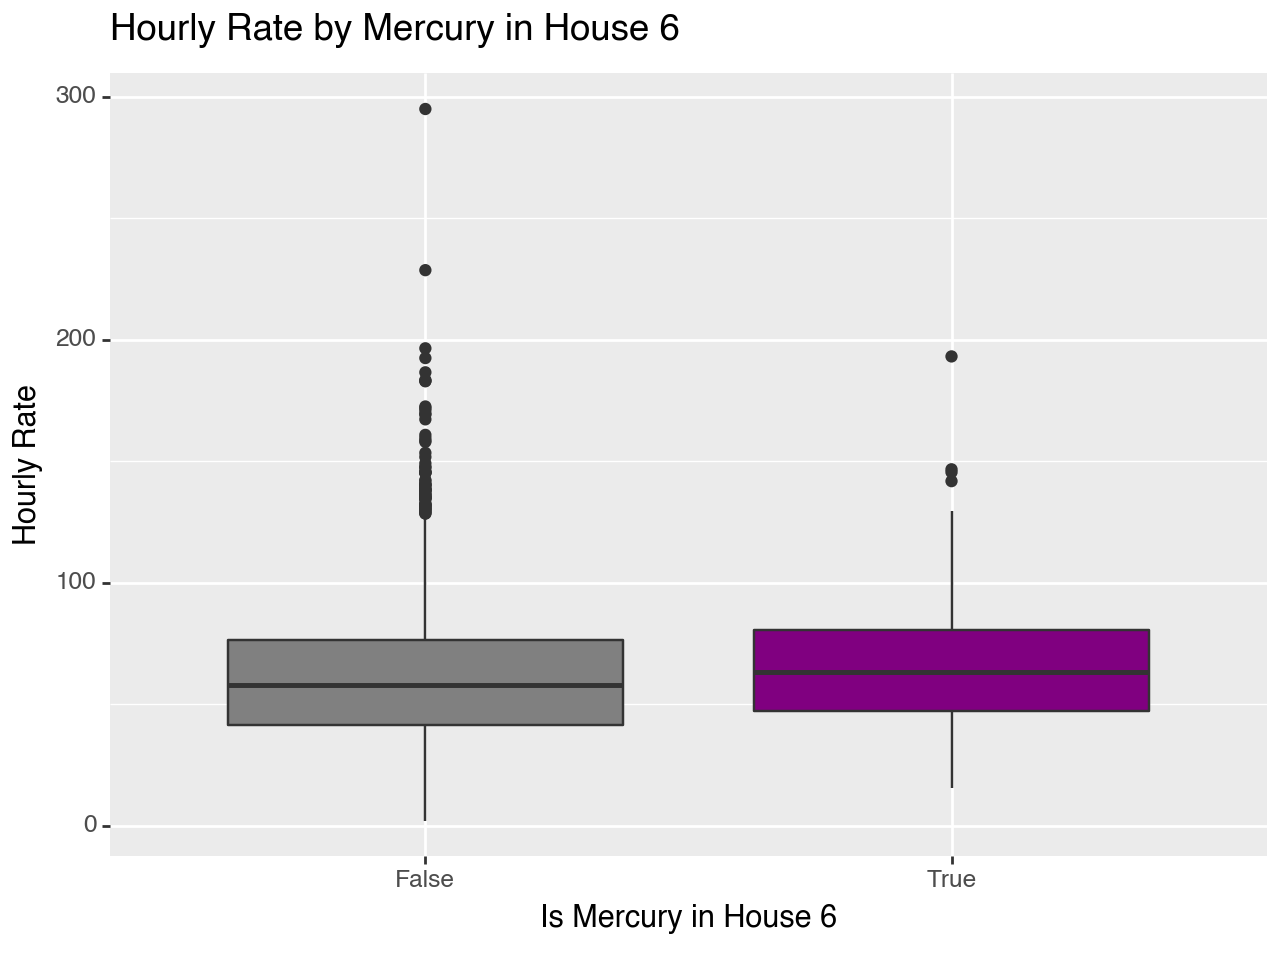

In [25]:
# Create binary variable that indicates if Mercury is in House 6
df['mercury_6'] = df['Mercury'] == 6

# Calculate the hourly rate
df['hourly_rate'] = (df['salary_in_usd'] / 52) / df['weekly_hours']  # Convert annual salary to weekly, then divide by weekly hours

# Create a box plot using plotnine without the legend
plot = (
    ggplot(df, aes(x='factor(mercury_6)', y='hourly_rate', fill='factor(mercury_6)')) +
    geom_boxplot() +
    scale_fill_manual(values={False: "grey", True: "purple"}) +  # Custom colors
    labs(
        title='Hourly Rate by Mercury in House 6',
        x='Is Mercury in House 6',
        y='Hourly Rate ($)'
    ) +
    theme(legend_position='none')  # This line removes the legend
)

# Display the plot
print(plot)

### 2.4. Ascendant elements within company sizes

The ascendant signs are associated with one's approach to life, intial reactions and ways in which we navigate new environment, such as work places. Thus, ascendant signs (as well as acendant elements), might give us insights into how an individual might adapt to feel comfortable within various organization strutuctures. Basing ourselves on traditional astrological interpretations we can argue the following.

Happiness in large companies, ranked:
1. Air ascendants: Typically social, communicative, and adaptable, air signs might thrive in large companies due to the diverse interactions and networking opportunities. They
2. Fire Ascendants: Fire signs are often ambitious, energetic, and driven, qualities that can serve well in the competitive atmosphere of large companies. 
3. Earth Ascendants: Practical, reliable, and hardworking, earth signs might appreciate the stability and structure of large companies
4. Water Ascendants (Cancer, Scorpio, Pisces): While water signs are empathetic, intuitive, and deeply emotional, they might find the impersonal nature of large companies challenging


Medium sized companies:
1. Earth ascendants
2. Fire ascendants
3. Air Ascendants
4. Water Ascendants

Small sized companies:
1. Water ascendants
2. Earth ascendants
3. Fire Ascendants
4. Air Ascenfants

In [19]:
df.columns

Index(['work_year', 'experience_level', 'employment_type', 'job_title',
       'salary', 'salary_currency', 'salary_in_usd', 'employee_residence',
       'remote_ratio', 'company_location', 'company_size', 'weekly_hours',
       'age', 'gender', 'job_title_grouped', 'birthday', 'longitude',
       'latitude', 'sun_position', 'moon_position', 'ascendant', 'sun_sign',
       'moon_sign', 'ascendant_sign', 'sun_element', 'Sun', 'Moon', 'Mercury',
       'Venus', 'Mars', 'Jupiter', 'Saturn', 'Uranus', 'Neptune', 'Pluto',
       'is_leadership', 'mercury_6', 'hourly_rate'],
      dtype='object')

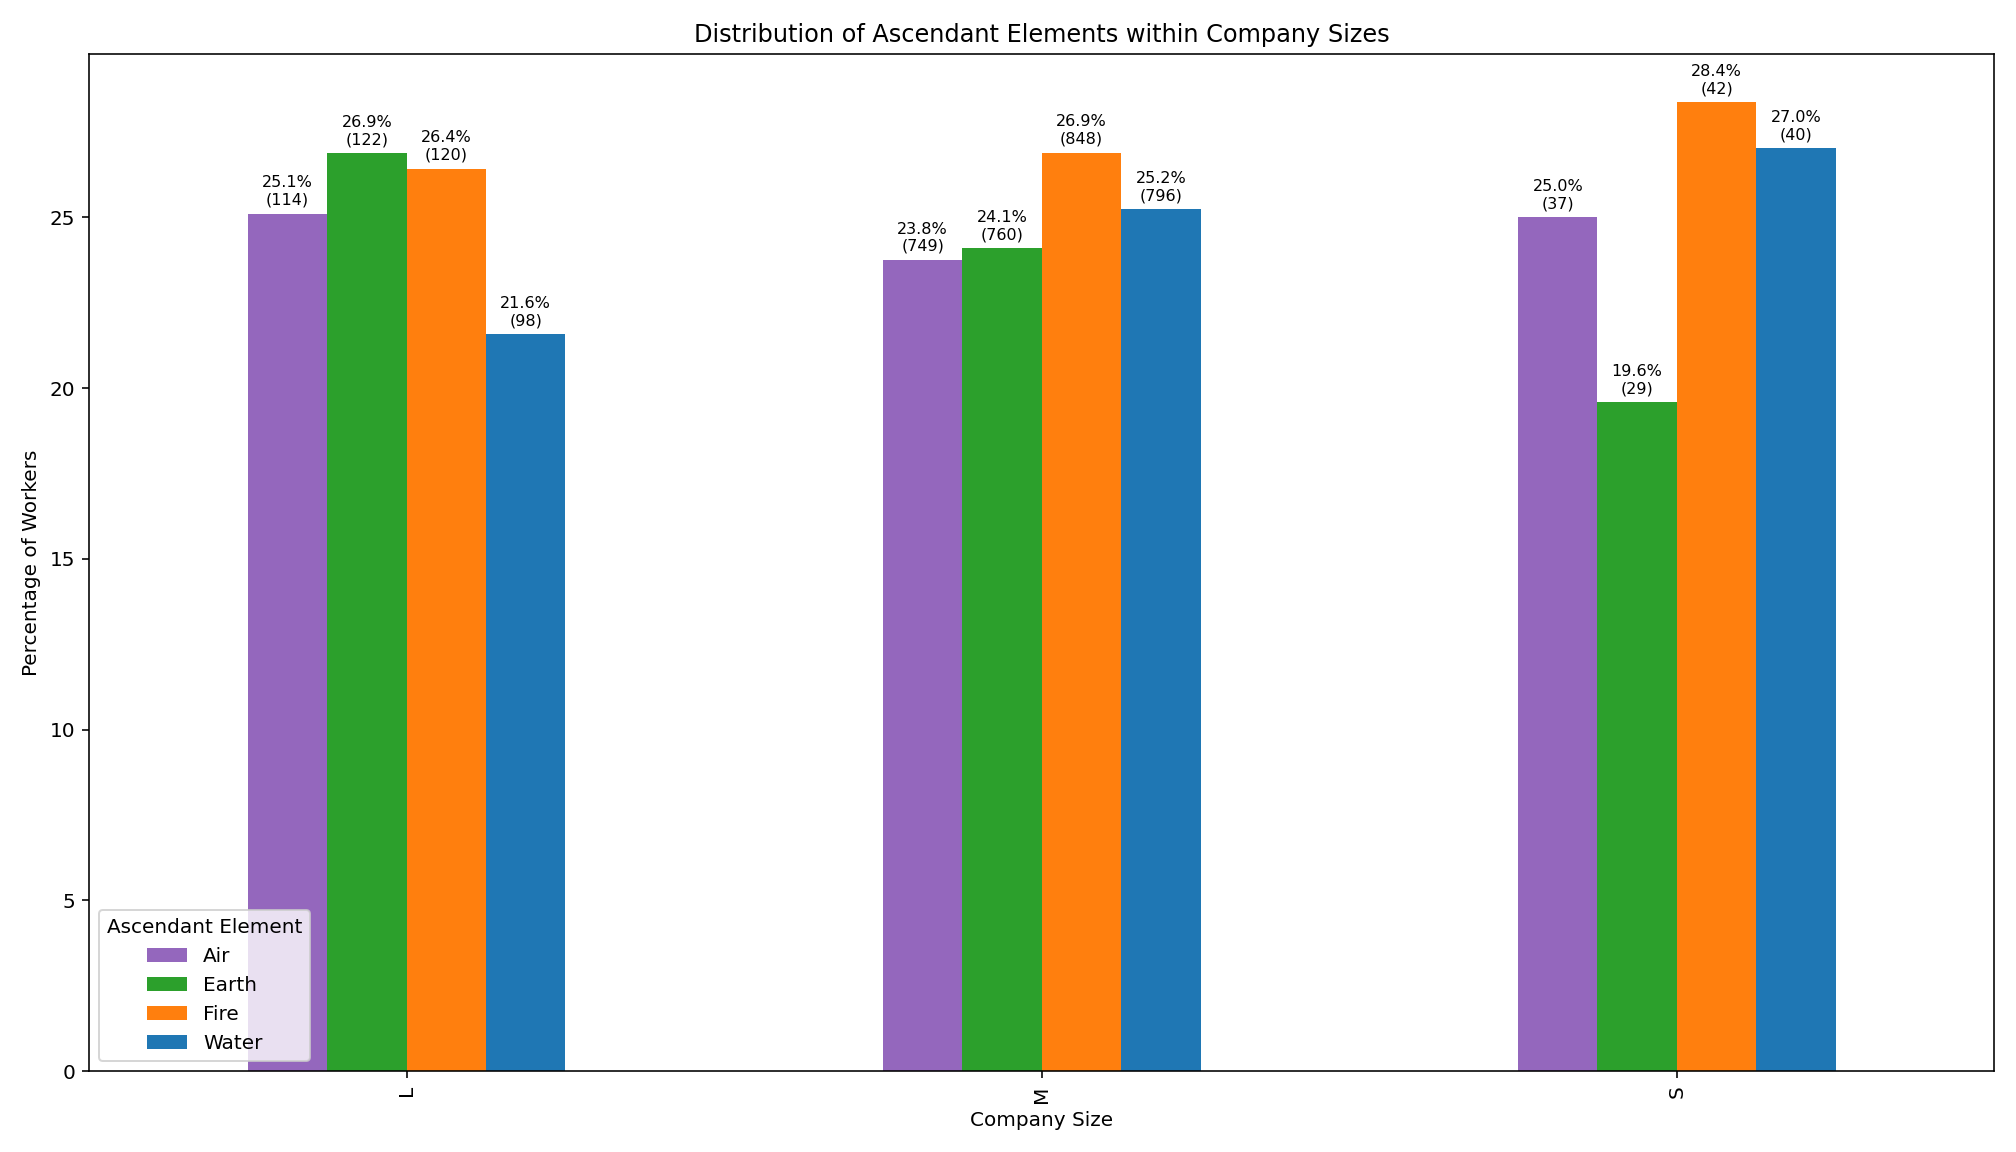

In [24]:
# Map Ascendant signs to elements
element_map = {
    'Aries': 'Fire', 'Leo': 'Fire', 'Sagittarius': 'Fire',
    'Taurus': 'Earth', 'Virgo': 'Earth', 'Capricorn': 'Earth',
    'Gemini': 'Air', 'Libra': 'Air', 'Aquarius': 'Air',
    'Cancer': 'Water', 'Scorpio': 'Water', 'Pisces': 'Water'
}

# Create a new column for Ascendant Element
df['ascendant_element'] = df['ascendant_sign'].map(element_map)

# Calculate the count of ascendant elements within each company size
element_distribution = df.groupby(['company_size', 'ascendant_element']).size().unstack(fill_value=0)

# Calculate the percentage distribution of ascendant elements within each company size
element_percentage = element_distribution.div(element_distribution.sum(axis=1), axis=0) * 100

# Update the colors mapping to the new color codes
colors = {'Fire': '#ff7f0e',  # Orange
    'Water': '#1f77b4',  # Blue
    'Air': '#9467bd',    # Purple
    'Earth': '#2ca02c'   # Green
}

# Plotting the percentage distribution as a grouped bar plot with the updated figure size and colors
ax = element_percentage.plot(kind='bar', figsize=(14, 8), color=[colors[element] for element in element_percentage.columns])
plt.title('Distribution of Ascendant Elements within Company Sizes')
plt.xlabel('Company Size')
plt.ylabel('Percentage of Workers')
plt.legend(title='Ascendant Element', loc='lower left')  # Moved legend to bottom left
plt.tight_layout()

# Annotating each bar with the percentage of workers and the number of workers, with adjusted font size
for bars, element in zip(ax.containers, element_distribution.columns):
    for bar, percentage, count in zip(bars, element_percentage[element], element_distribution[element]):
        ax.annotate(f'{percentage:.1f}%\n({count})', xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()), xytext=(0, 3), textcoords='offset points', ha='center', va='bottom', fontsize=8)

# Show the plot
plt.show()

### 2.5. Astrological Characteristics of top 10%

In [21]:

# Calculate the threshold for the top 10% earners in the dataset
threshold = df["salary_in_usd"].quantile(0.9)

# Filter the dataset for top 10% earners
top_earners = df[df["salary_in_usd"] >= threshold]

# List of planets for which we want to calculate the most common placement
planets_columns = ["Moon", "Mercury", "Venus", "Mars", "Jupiter", "Saturn", "Uranus", "Neptune", "Pluto"]

# Initialize a dictionary to store the results
results = {}

# Calculate the most common placement and its percentage for each planet
for planet in planets_columns:
    # Exclude NaN values for the calculation
    valid_data = top_earners[planet].dropna()
    if not valid_data.empty:
        mode_value = valid_data.mode().iloc[0]
        count = valid_data[valid_data == mode_value].count()
        total_valid = valid_data.count()
        percentage = round((count / total_valid) * 100,0)
    else:
        mode_value = 'NaN'
        count = 0
        total_valid = 0
        percentage = 0

    # Store the results in the dictionary
    results[planet] = {
        'Planet': planet,
        'Most Common Placement': mode_value,
        'Adjusted Percentage (%)': percentage
    }

# Convert the results dictionary to a DataFrame for easier viewing
results_df = pd.DataFrame.from_dict(results, orient='index')

# Optionally, you might want to reorder or rename columns as necessary to match your table structure

# Display or return the DataFrame
results_df


,Planet,Most Common Placement,Adjusted Percentage (%)
Moon,Moon,1,13.0
Mercury,Mercury,9,16.0
Venus,Venus,8,16.0
Mars,Mars,8,17.0
Jupiter,Jupiter,9,13.0
Saturn,Saturn,9,17.0
Uranus,Uranus,5,17.0
Neptune,Neptune,5,21.0
Pluto,Pluto,3,18.0
